In [2]:
import anndata
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scanpy as sc
from sklearn.cluster import MiniBatchKMeans

from mcDETECT.utils import *
from mcDETECT.model import *
from mcDETECT.downstream import *

import warnings
warnings.filterwarnings("ignore")
sc.settings.verbosity = 0

In [3]:
# File paths
dataset = "MERSCOPE_WT_1"
data_path = f"../data/{dataset}/"
output_path = f"../output/{dataset}/"
comparison_path = f"../output/MERSCOPE_WT_AD_comparison/"

In [4]:
# -------------------- Read data -------------------- #

# Cells
adata = sc.read_h5ad(data_path + "processed_data/adata.h5ad")

# Neurons
adata_neuron = adata[adata.obs["cell_type"].isin(["Glutamatergic", "GABAergic"])].copy()

# Transcripts
transcripts = pd.read_parquet(data_path + "processed_data/transcripts.parquet")

# Genes
genes = pd.read_csv(data_path + "processed_data/genes.csv")
genes = list(genes.iloc[:, 0])

# Negative control markers
nc_genes = pd.read_csv(data_path + "processed_data/negative_controls.csv")
nc_genes = list(nc_genes["Gene"])

# Spots
spots = sc.read_h5ad(data_path + "processed_data/spots.h5ad")

In [5]:
# Marker genes
marker_genes = {"pre-syn": ["Bsn", "Gap43", "Nrxn1", "Slc17a6", "Slc17a7", "Slc32a1", "Snap25", "Stx1a", "Syn1", "Syp", "Syt1", "Vamp2", "Cplx2"],
                "post-syn": ["Camk2a", "Dlg3", "Dlg4", "Gphn", "Gria1", "Gria2", "Homer1", "Homer2", "Nlgn1", "Nlgn2", "Nlgn3", "Shank1", "Shank3"],
                "axons": ["Ank3", "Nav1", "Sptnb4", "Nfasc", "Mapt", "Tubb3"],
                "dendrites": ["Actb", "Cyfip2", "Ddn", "Dlg4", "Map1a", "Map2"]}

ref_genes = list(set(marker_genes["pre-syn"] + marker_genes["post-syn"] + marker_genes["axons"] + marker_genes["dendrites"]))
ref_genes = list(set(ref_genes) & set(genes))
print(len(ref_genes))

34


In [6]:
# Read granule adata
granule_adata = sc.read_h5ad(output_path + "granule_adata_tsne.h5ad")
granule_adata

AnnData object with n_obs × n_vars = 681337 × 290
    obs: 'global_x', 'global_y', 'global_z', 'layer_z', 'sphere_r', 'size', 'comp', 'in_soma_ratio', 'gene', 'nc_ratio', 'granule_id'
    var: 'genes'
    uns: 'log1p', 'pca', 'tsne'
    obsm: 'X_pca', 'X_tsne'
    varm: 'PCs'
    layers: 'counts'

In [7]:
# Subset granule adata
granule_adata_subset = granule_adata[:, ref_genes].copy()
granule_adata_subset

AnnData object with n_obs × n_vars = 681337 × 34
    obs: 'global_x', 'global_y', 'global_z', 'layer_z', 'sphere_r', 'size', 'comp', 'in_soma_ratio', 'gene', 'nc_ratio', 'granule_id'
    var: 'genes'
    uns: 'log1p', 'pca', 'tsne'
    obsm: 'X_pca', 'X_tsne'
    varm: 'PCs'
    layers: 'counts'

### Manual annotation

In [8]:
# K-Means clustering
data = granule_adata_subset.X.copy()
if not isinstance(data, np.ndarray):
    data = data.toarray()

n_clusters = 15
kmeans = MiniBatchKMeans(n_clusters = n_clusters, batch_size = 5000, random_state = 10, n_init = 50)
kmeans.fit(data)
granule_adata.obs["granule_subtype_kmeans"] = kmeans.labels_.astype(str)

desired_order = [f"{i}" for i in range(n_clusters)]
granule_adata.obs["granule_subtype_kmeans"] = pd.Categorical(granule_adata.obs["granule_subtype_kmeans"], categories=desired_order, ordered=True)

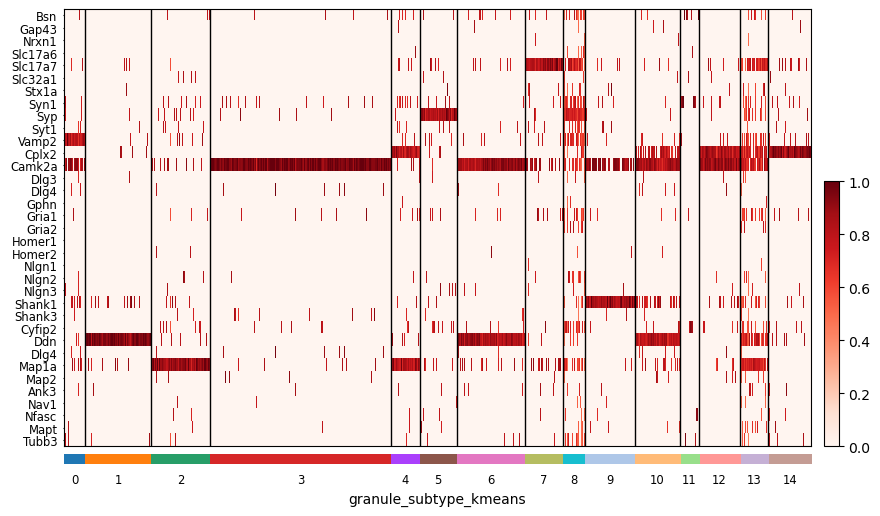

In [9]:
# Plot granule subtype heatmap
ref_genes_sorted = ["Bsn", "Gap43", "Nrxn1", "Slc17a6", "Slc17a7", "Slc32a1", "Stx1a", "Syn1", "Syp", "Syt1", "Vamp2", "Cplx2", "Camk2a", "Dlg3", "Dlg4", "Gphn", "Gria1", "Gria2", "Homer1", "Homer2", "Nlgn1", "Nlgn2", "Nlgn3", "Shank1", "Shank3", "Cyfip2", "Ddn", "Dlg4", "Map1a", "Map2", "Ank3", "Nav1", "Nfasc", "Mapt", "Tubb3"]
granule_adata_subset.obs["granule_subtype_kmeans"] = pd.Categorical(granule_adata.obs["granule_subtype_kmeans"])
granule_adata_subset.obs["granule_subtype_kmeans"] = pd.Categorical(granule_adata_subset.obs["granule_subtype_kmeans"], categories=[str(i) for i in range(n_clusters)], ordered=True)

ax = sc.pl.heatmap(granule_adata_subset, var_names = ref_genes_sorted, groupby = "granule_subtype_kmeans", cmap = "Reds", standard_scale = "var", dendrogram = False, swap_axes = True, show = False, figsize = (10, 6))
plt.show()

In [10]:
# Manual subtyping
pre_list = ["5", "7", "14"]
post_list = ["3", "9"]
den_list = ["1", "2"]
axon_list = []
pre_post_list = ["0", "12"]
pre_den_list = ["4"]
post_den_list = ["6"]
pre_post_den_list = ["8", "10", "13"]
others_list = ["11"]

subtype_dict = {"pre-syn": pre_list, "post-syn": post_list, "pre & post": pre_post_list, "pre & den": pre_den_list, "post & den": post_den_list, "pre & post & den": pre_post_den_list, "dendrites": den_list, "axons": axon_list, "others": others_list}
granule_adata.obs["granule_subtype"] = np.nan
for i in subtype_dict.keys():
    ind = pd.Series(granule_adata.obs["granule_subtype_kmeans"]).isin(subtype_dict[i])
    granule_adata.obs.loc[ind, "granule_subtype"] = i
granule_adata.obs["granule_subtype"] = pd.Categorical(granule_adata.obs["granule_subtype"], categories=["pre-syn", "post-syn", "pre & post", "pre & den", "post & den", "pre & post & den", "dendrites", "axons", "others"], ordered=True)
granule_adata.obs["granule_subtype"] = granule_adata.obs["granule_subtype"].cat.remove_unused_categories()
granule_adata.obs["granule_subtype_manual"] = granule_adata.obs["granule_subtype"].apply(lambda s: "mixed" if " & " in str(s) else str(s))

In [11]:
pd.DataFrame({"Proportion": (granule_adata.obs["granule_subtype_manual"].value_counts(normalize=True).sort_index() * 100).round(2)})

,Proportion
granule_subtype_manual,
dendrites,16.68
mixed,34.06
others,2.54
post-syn,30.92
pre-syn,15.80


### Automatic annotation with clustering

In [12]:
# Define parameter ranges
enrich_thresholds = [0.2, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50]
zscore_thresholds = [-0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5]

results = []

for enrich_thr in enrich_thresholds:
    for zscore_thr in zscore_thresholds:
        subtypes, subtypes_simple = classify_granules(
            granule_adata,
            cluster_column="granule_subtype_kmeans",
            enrichment_threshold=enrich_thr,
            min_zscore_threshold=zscore_thr,
            custom_markers=marker_genes
        )
        
        counts = subtypes_simple.value_counts(normalize=True)
        
        results.append({
            'enrich_thr': enrich_thr,
            'zscore_thr': zscore_thr,
            'pre-syn': counts.get('pre-syn', 0),
            'post-syn': counts.get('post-syn', 0),
            'dendrites': counts.get('dendrites', 0),
            'axons': counts.get('axons', 0),
            'mixed': counts.get('mixed', 0),
            'others': counts.get('others', 0)
        })

results_df = pd.DataFrame(results)

In [13]:
manual_dist = {
    'pre-syn': 0.1580,
    'post-syn': 0.3092,
    'dendrites': 0.1668,
    'axons': 0.0000,
    'mixed': 0.3406,
    'others': 0.0254
}

In [14]:
dist_cols = ['pre-syn', 'post-syn', 'dendrites', 'axons', 'mixed', 'others']

manual = pd.Series(manual_dist).reindex(dist_cols).fillna(0)

results_df["least_square_error"] = ((results_df[dist_cols].sub(manual, axis=1))**2).sum(axis=1)

best = results_df.sort_values("least_square_error", ascending=True)
best.head(10)

,enrich_thr,zscore_thr,pre-syn,post-syn,dendrites,axons,mixed,others,least_square_error
0,0.2,-0.50,0.161607,0.309177,0.166772,0,0.362443,0.0,0.001135
7,0.2,1.25,0.161607,0.309177,0.166772,0,0.362443,0.0,0.001135
6,0.2,1.00,0.161607,0.309177,0.166772,0,0.362443,0.0,0.001135
5,0.2,0.75,0.161607,0.309177,0.166772,0,0.362443,0.0,0.001135
8,0.2,1.50,0.161607,0.309177,0.166772,0,0.362443,0.0,0.001135
3,0.2,0.25,0.161607,0.309177,0.166772,0,0.362443,0.0,0.001135
2,0.2,0.00,0.161607,0.309177,0.166772,0,0.362443,0.0,0.001135
1,0.2,-0.25,0.161607,0.309177,0.166772,0,0.362443,0.0,0.001135
4,0.2,0.50,0.161607,0.309177,0.166772,0,0.362443,0.0,0.001135
19,0.3,-0.25,0.212362,0.309177,0.166772,0,0.311689,0.0,0.004436


### Automatic annotation without clustering

In [ ]:
for enrich_thr in enrich_thresholds:
    for zscore_thr in zscore_thresholds:
        subtypes, subtypes_simple = classify_granules(
            granule_adata,
            cluster_column=None,
            enrichment_threshold=enrich_thr,
            min_zscore_threshold=zscore_thr,
            custom_markers=marker_genes
        )
        
        counts = subtypes_simple.value_counts(normalize=True)
        
        results.append({
            'enrich_thr': enrich_thr,
            'zscore_thr': zscore_thr,
            'pre-syn': counts.get('pre-syn', 0),
            'post-syn': counts.get('post-syn', 0),
            'dendrites': counts.get('dendrites', 0),
            'axons': counts.get('axons', 0),
            'mixed': counts.get('mixed', 0),
            'others': counts.get('others', 0)
        })
        
        print(f"Enrichment threshold: {enrich_thr}, Z-score threshold: {zscore_thr}")

results_df = pd.DataFrame(results)

Enrichment threshold: 0.2, Z-score threshold: -0.5
Enrichment threshold: 0.2, Z-score threshold: -0.25
Enrichment threshold: 0.2, Z-score threshold: 0.0
Enrichment threshold: 0.2, Z-score threshold: 0.25
Enrichment threshold: 0.2, Z-score threshold: 0.5
Enrichment threshold: 0.2, Z-score threshold: 0.75
Enrichment threshold: 0.2, Z-score threshold: 1.0
Enrichment threshold: 0.2, Z-score threshold: 1.25
Enrichment threshold: 0.2, Z-score threshold: 1.5
Enrichment threshold: 0.25, Z-score threshold: -0.5
Enrichment threshold: 0.25, Z-score threshold: -0.25
Enrichment threshold: 0.25, Z-score threshold: 0.0
Enrichment threshold: 0.25, Z-score threshold: 0.25
Enrichment threshold: 0.25, Z-score threshold: 0.5
Enrichment threshold: 0.25, Z-score threshold: 0.75
Enrichment threshold: 0.25, Z-score threshold: 1.0
Enrichment threshold: 0.25, Z-score threshold: 1.25
Enrichment threshold: 0.25, Z-score threshold: 1.5
Enrichment threshold: 0.3, Z-score threshold: -0.5
Enrichment threshold: 0.3, Z